# Введение в искусственные нейронные сети
# Урок 6. Автокодировщики. Сегментация

## Практическое задание

Вариант 1

1. построить автоэнкодер для Mnist (изменять коэффициент зашумления (0.1, 0.4, 0.9)) - получить результат

2. оценить точность по коэффициенту Дици

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Input, MaxPooling2D

%matplotlib inline

**Коэффициент Дици (Дайса, Сёренсена) как метрика качества**

In [0]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

**Данные MNIST**

In [0]:
(train_images, _), (test_images, __) = mnist.load_data()

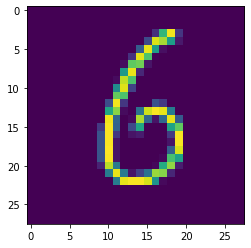

In [4]:
plt.imshow(train_images[18])
plt.show()

In [5]:
train_images.shape

(60000, 28, 28)

**Функция подготовки данных**

Исходные изображения для обучения и теста преобразовываются в две группы:

 - X_train, X_test (входные данные: исходные данные с задаваемым уровнем аддитивного шума);
 - Y_train, Y_test (выходные данные: исходные данные без шума).

In [0]:
def prepare_pics(train_images, test_images, noise=1, random_state=21):
    np.random.seed(random_state)

    X_train = train_images.astype('float32') / 255
    X_test = test_images.astype('float32') / 255

    Y_train = X_train.copy()
    Y_test = X_test.copy()

    x, y, z = X_train.shape
    X_train += np.random.randn(x, y, z) * noise

    x, y, z = X_test.shape
    X_test += np.random.randn(x, y, z) * noise

    return X_train, X_test, Y_train, Y_test

**Функция построения и компиляции автоэнкодера**

In [0]:
def base_autoencoder(input_size=(28, 28, 1)):

    img_input = Input(input_size)
    pool_size = (2, 2)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)
   
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)

    x = Conv2DTranspose(64, pool_size, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)     
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, pool_size, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
   
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[dice_coef])

    return model

**Перебором по заданным уровням аадитивного шума:**
 - создаем выборки для обучения (X_train, Y_train) и теста (X_test, Y_test);
 - показываем пример воздействия шума на изображение;
 - с помощью выборки для обучения обучаем автоэнкодер;
 - оцениваем его качество на тестовой выборке коэффициентом Сёренсена.

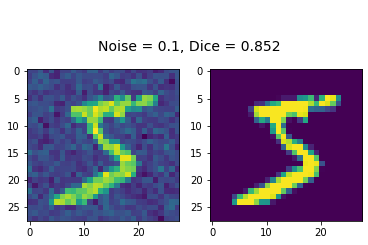

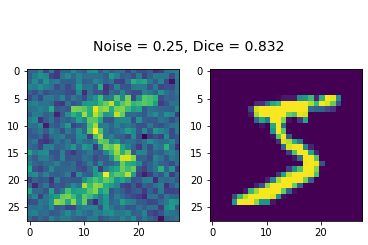

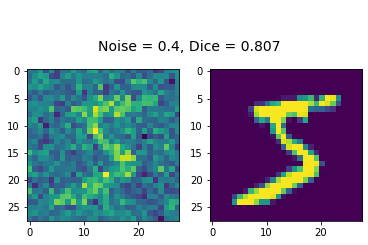

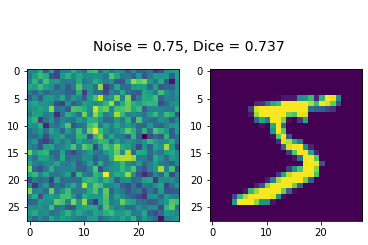

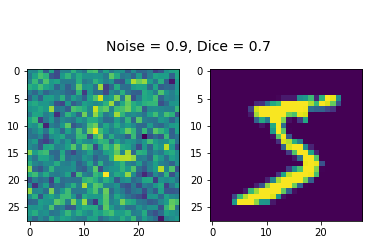

In [120]:
noise_levels = [0.1, 0.25, 0.4, 0.75,0.9]
dice_coeffs = []

for noise in noise_levels:
    X_train, X_test, Y_train, Y_test = prepare_pics(train_images, test_images, noise)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for ax, img in zip(axes, [X_train[0], Y_train[0]]):
        ax.imshow(img)

    model = base_autoencoder()
    history = model.fit(X_train, Y_train, epochs=15, batch_size=100, validation_split=0.2, verbose=0)

    test_loss, test_dice = model.evaluate(X_test, Y_test, verbose=0)
    dice_coeffs.append(test_dice)

    plt.suptitle(f'\n\nNoise = {noise}, Dice = {round(test_dice, 3)}', fontsize=14)
    plt.show()

**Зависимость коэффициента Сёренсена от уровня зашумленности изображения**

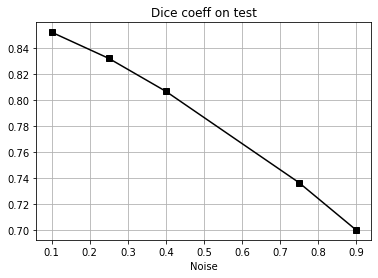

In [128]:
plt.plot(noise_levels, dice_coeffs, c='k', marker='s')
plt.title('Dice coeff on test')
plt.xlabel('Noise')
plt.grid(True)
plt.show()

С повышением уровня аддитивного шума коэффициент Сёренсена монотонно убывает.